> This is a rework of my task during Machine Learning class in 2022.

> Goal(s):
- to construct a model using the Gradient Descent based Logistic Regression approach (scratch) to classify the given dataset.

> References **[A]**:
1.  https://www.scribbr.com/statistics/correlation-coefficient/
2.  https://www.statology.org/multicollinearity-regression/
3.  https://online.stat.psu.edu/stat462/node/180/
4.  https://stephenallwright.com/interpret-auc-score/

> References **[B]**:
*  Class/University notes
*  https://medium.com/analytics-vidhya/logistic-regression-with-gradient-descent-explained-machine-learning-a9a12b38d710
*  https://web.stanford.edu/~jurafsky/slp3/5.pdf

# Import Essentials

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor 

## Dataset

In [2]:
X_train = np.array([[0.08, 0.72], [0.26, 0.58], [0.45, 0.15], [0.60, 0.30], [0.10, 1.0], [0.35, 0.95], [0.70, 0.65], [0.92, 0.45]])
Y_train = np.array([1, 1, 1, 1, 0, 0, 0, 0])
X_test = np.array([[0.10, 0.9], [0.4, 0.2], [0.8, 0.5], [0.2, 0.6]])

# Dataset Overview

In [3]:
data_train = pd.DataFrame({
  'x1' : X_train[:, 0],
  'x2' : X_train[:, 1],
  'y' : Y_train
})
data_train.head()

,x1,x2,y
0,0.08,0.72,1
1,0.26,0.58,1
2,0.45,0.15,1
3,0.60,0.30,1
4,0.10,1.00,0


In [4]:
data_train['y'].value_counts()

y
1    4
0    4
Name: count, dtype: int64

> The data class is well distributed.

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      8 non-null      float64
 1   x2      8 non-null      float64
 2   y       8 non-null      int32  
dtypes: float64(2), int32(1)
memory usage: 292.0 bytes


> This training dataset consists of both independent (all numerical) and dependent variables of equal length with no null values. Therefore, there is no need to proceed to the Handling Missing/Error Value step.

> Given the small size of the dataset, which consists of only 8 rows, in my opinion, it is not necessary to split it into training and testing sets.

In [6]:
data_train.describe()

,x1,x2,y
count,8.000000,8.000000,8.000000
mean,0.432500,0.600000,0.500000
std,0.294946,0.296359,0.534522
min,0.080000,0.150000,0.000000
25%,0.220000,0.412500,0.000000
50%,0.400000,0.615000,0.500000
75%,0.625000,0.777500,1.000000
max,0.920000,1.000000,1.000000


> Each numerical independent columns has min and max values range from 0 to 1. Therefore, in my opinion, there appears to be no immediate need for standardization or normalization. However, it could be considered after conducting Exploratory Data Analysis (EDA).

In [7]:
numvar_col = ['x1', 'x2']

# Exploratory Data Analysis (EDA)

In [8]:
def visualize_numvar(df, col_names, col_target, type):
  data = df[col_names]
  rows = np.ceil((len(data.columns)) / 2).astype(int)
  fig, axs = plt.subplots(rows, 2, figsize=(6, 3))
  axs = axs.flatten()
  for idx, col_name in enumerate(col_names):
    if(type == 'dist'):
      sns.histplot(data[col_name], ax=axs[idx], kde=True)
      axs[idx].set_title(f"Distribution Plot ({col_name})")
    elif(type == 'box'):
      sns.boxplot(x=df[col_target], y=data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Box Plot ({col_name})")
    elif(type == 'scatter'):
      sns.scatterplot(data[col_name], ax=axs[idx])
      axs[idx].set_title(f"Scatter Plot ({col_name})")
  plt.tight_layout()
  plt.show()

## Distribution Plot

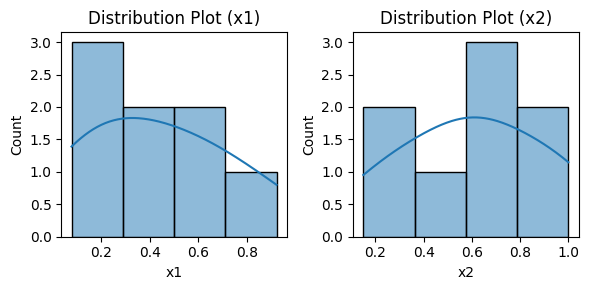

In [9]:
visualize_numvar(data_train, numvar_col, 'y', 'dist')

> Since the dataset seems initially normalized (scaled between 0 and 1) and one of the distributions is only slightly skewed, in my opinion, it is unnecessary to proceed to the the Feature Transformation step.

## Box Plot

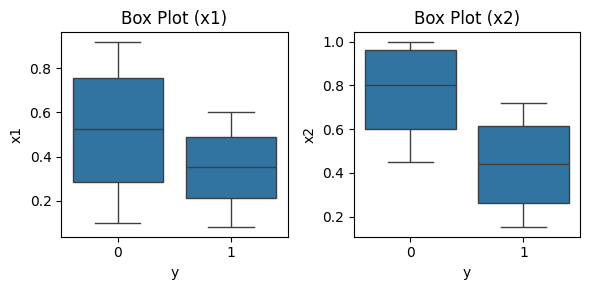

In [10]:
visualize_numvar(data_train, numvar_col, 'y', 'box')

> Based on the graph above, it seems that there is no outliers on the dataset.

## Scatter Plot

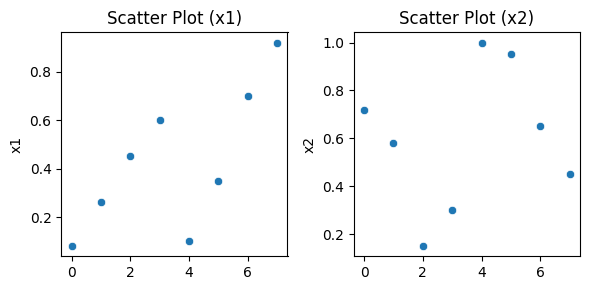

In [11]:
visualize_numvar(data_train, numvar_col, 'y', 'scatter')

## Correlation Analysis

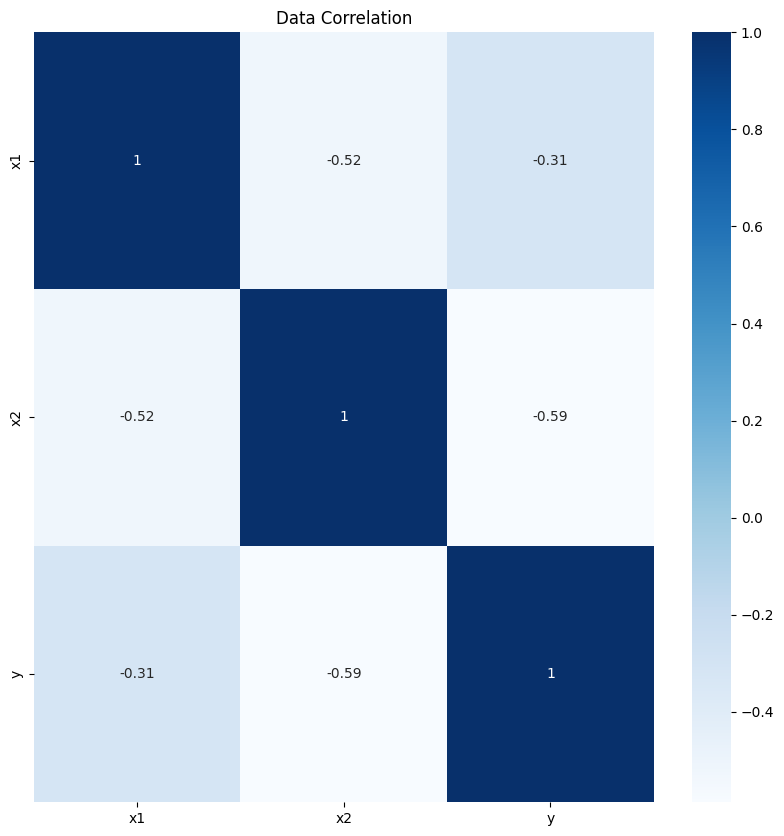

In [12]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_train.corr(), cmap='Blues', annot=True) 
plt.title('Data Correlation')
plt.show()

> It's noteworthy that the correlation between the independent variables and dependent variable ranges from -0.3 to -0.6, which indicate a moderate to strong negative relationship [1]. Furthermore, since the dataset columns labeled merely as "x1", "x2", and "y" without any further context, in my opinion, it is necessary to include all columns.

In [13]:
def generate_VIF(data):
  vif_data = pd.DataFrame({
    'feature' : data.columns,
    'VIF' : [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
  })
  print(vif_data)

In [14]:
generate_VIF(data_train)

  feature       VIF
0      x1  1.849426
1      x2  1.824923
2       y  1.374193


> The obtained Variance Inflation Factor (VIF) for independent variables in the dataset ranges from 1.824923 to 1.849426, which indicate a moderate correlation which is often not severe enough to require attention [2]. Therefore, based on this result, it can be concluded that each variable brings some unique information to the model, but there is no need for concern about multicollinearity affecting the estimates of the coefficients.

## Visualizing

In [15]:
def visualize(data, title, column_name, xlabel, ylabel):
  groups_train = data.groupby(column_name)
  colors = {0 : 'red', 1 : 'blue'}
  for key, data in groups_train:
    plt.scatter(data[xlabel], data[ylabel], label = key, color = colors[key])
  plt.legend()
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

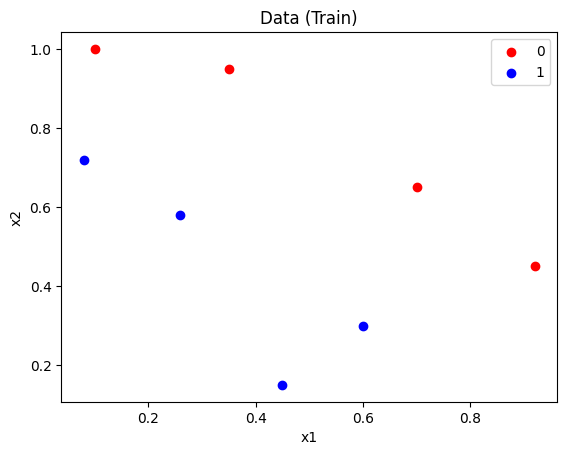

In [16]:
visualize(data_train, 'Data (Train)', 'y', 'x1', 'x2')

# Model Building

## Explanation

> Here is $z$, a linear combination which also often called as logit, where $w$ as weight, $x$ as input feature(s), and $b$ as bias.

> 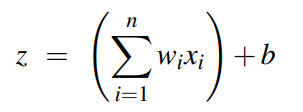

> To create a probability, we need to pass $z$ through the sigmoid function, which also often called as logistic function. This formula transform into a probability range between 0 and 1, which the result can be used as predicted value of y.

> 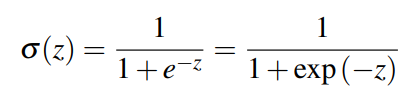

> In order to know the difference between the predicted value of y and the actual value of y, since there are only 2 outcomes, we can use Bernoulli Distribution where is $p$ is the probability of success and $1-p$ is the probability of failure.

> $P(Y = y) = p^y * (1-p)^{1-y}$

> Then, the maximum likelihood as follow:

> $L(β) = Π_{i=1}^n p_i^{y_i} * (1-p_i)^{1-y_i}$

> Finally, using log on both side to simplify the equation as follow:

> $l(β) = Σ_{i=1}^n y_i * log(p_i) + (1-y_i) * log(1-p_i)$

> To turn this into a loss function (loss):

> 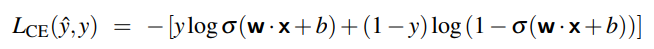

> Next, to optimize the model, then we need to minimize the loss, which we can do by finding the optimal weights and bias:

> 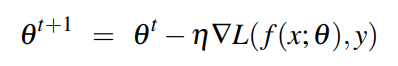

> 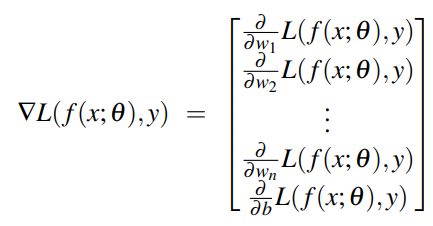

> 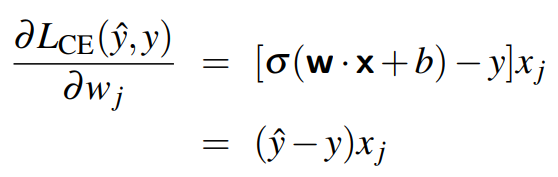

## Finding Parameters

In [17]:
class logistic_regression:
  def __init__(self, w, b):
    self.w = w
    self.b = b

  def sigmoid(self, x):
    return (1 / (1 + np.exp(-1 * (np.dot(x, self.w) + self.b))))

  def update_w(self, x, y, y_predict):
    return np.dot((y_predict - y), x)

  def update_b(self, y, y_predict):
    return sum(y_predict - y)

  def loss_function(self, y, y_predict):
    return (-1 * sum(y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict)))

  def fit(self, x, y, learn_rate, epochs):
    loss = []
    for i in range(epochs):
      y_predict = self.sigmoid(x)
      self.b = self.b - learn_rate * self.update_b(y, y_predict)
      self.w = self.w - learn_rate * self.update_w(x, y, y_predict)
      loss.append(self.loss_function(y, y_predict))
    return loss

In [18]:
def loss_visualization(loss, learn_rate, epochs):
  for i in range(len(loss)):
    plt.plot(np.arange(1, epochs), loss[i][1:], label=learn_rate[i])
  plt.title('Number of Epochs vs Loss')
  plt.xlabel('Number of Epochs', size=10)
  plt.ylabel('Loss', size=10)
  plt.legend()

> Besides weights and bias, we also need to optimize the learning rate. In this case, we will try using several learning rates to see the most effective learning rates with this dataset.

In [19]:
losses, w, b = [], [], []
learn_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
epochs = 50000

for i in range(len(learn_rates)):
  model = logistic_regression(np.zeros(X_train.shape[1]), 0)
  losses.append(model.fit(X_train, Y_train, learn_rates[i], epochs))
  w.append(model.w)
  b.append(model.b)

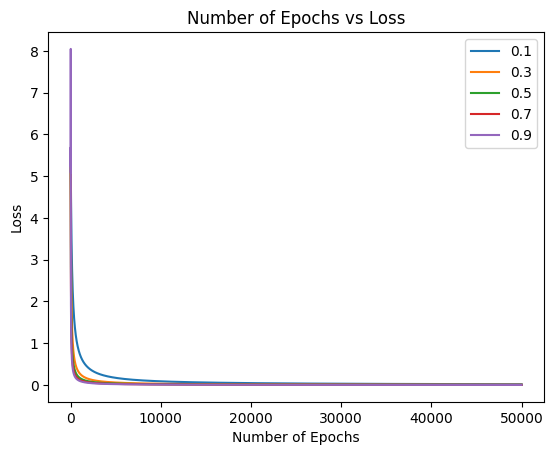

In [20]:
loss_visualization(losses, learn_rates, epochs)

In [21]:
loss = []
for i in range(len(learn_rates)):
  loss.append([learn_rates[i], losses[i][epochs - 2]])
loss = sorted(loss, key=lambda x:x[1])
print(f"Learning rate ({loss[0][0]}) produces smallest loss: {loss[0][1]}")

Learning rate (0.9) produces smallest loss: 0.0021610277038588404


> Based on the results above, it can be concluded that learning rate 0.9 is the most effective in minimizing the loss on this dataset (closest to 0).

In [22]:
print(f"Weights: {w[4]}")
print(f"Bias: {b[4]}")

Weights: [-34.44807276 -48.92226138]
Bias: 45.2175973790372


> This weights and bias will be used on the final model in the next part.

## Train The Final Model

In [23]:
loss = []
learn_rate = [0.9]
model_final = logistic_regression(w[4], b[4])
loss.append(model_final.fit(X_train, Y_train, learn_rates[0], epochs))

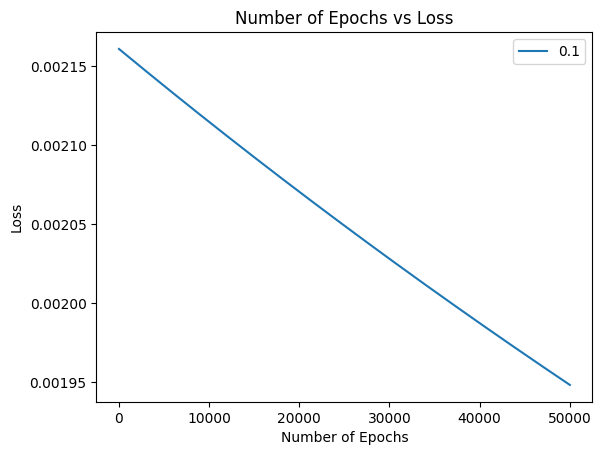

In [24]:
loss_visualization(loss, learn_rates, epochs)

In [25]:
print(f"Weights: {model_final.w}")
print(f"Bias: {model_final.b}")

Weights: [-34.91229849 -49.59949403]
Bias: 45.84039008643861


# Model Evaluation

In [26]:
def threshold(y):
  return [0 if y[i] <= 0.5 else 1 for i in range(y.size)]

In [27]:
data_train['y predict'] = threshold(model_final.sigmoid(X_train))
data_train.head()

,x1,x2,y,y predict
0,0.08,0.72,1,1
1,0.26,0.58,1,1
2,0.45,0.15,1,1
3,0.60,0.30,1,1
4,0.10,1.00,0,0


In [28]:
def conf_matrix(data_A, data_B):
  sns.heatmap(confusion_matrix(data_A, data_B), annot = True, cmap = 'Greys')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Values')
  plt.ylabel('Actual Values')
  plt.show()

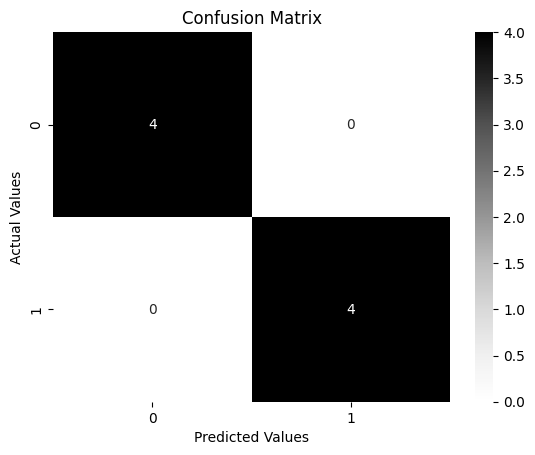

In [29]:
conf_matrix(data_train['y'], data_train['y predict'])

In [30]:
print(classification_report(data_train['y'], data_train['y predict']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [31]:
print(f"ROC AUC score: {roc_auc_score(data_train['y'], data_train['y predict']):.3f}")

ROC AUC score: 1.000


> This model achieved a Receiver Operating Characteristic Area Under the Curve (ROC AUC) score of 1, which is the maximum possible value [4]. This indicates that the model has an excellent discriminative ability, being able to perfectly distinguish between the classes in the dataset. In addition, this model also achieved a perfect F1 and accuracy score and a confusion matrix with no misclassifications.

> Hence, it can be concluded that this final model made accurate predictions that match with the actual values. However, overfitting may occur because the model was trained on the training dataset and used the same dataset for validation (it may not perform as well when it encounters new, unseen data).

## Predict using Test Dataset

In [32]:
Y_predict = threshold(model_final.sigmoid(X_test))

In [33]:
data_test = pd.DataFrame({
  'x1' : X_test[:, 0],
  'x2' : X_test[:, 1],
  'y predict' : Y_predict
})
data_test

,x1,x2,y predict
0,0.1,0.9,0
1,0.4,0.2,1
2,0.8,0.5,0
3,0.2,0.6,1


> However, without the actual values for the dependent variable in the testing dataset, a comprehensive evaluation of the model's performance on new, unseen data is not feasible.

> After obtaining the y values as the prediction results from the testing dataset, visualization will be conducted.

## Visualize Data (Testing Dataset)

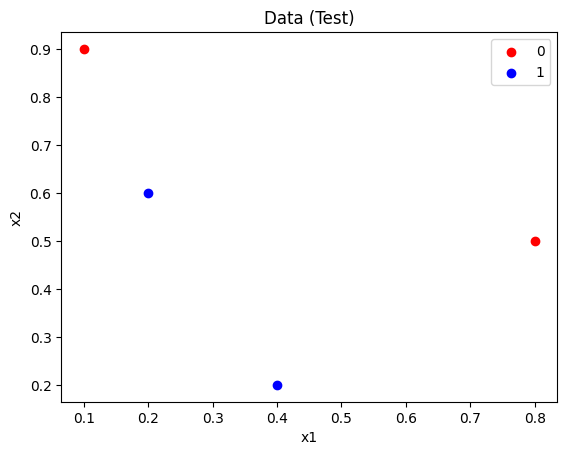

In [34]:
visualize(data_test, 'Data (Test)', 'y predict', 'x1', 'x2')

# Visualization

In [35]:
data = pd.DataFrame({
  'x1' : np.concatenate((X_train, X_test))[:, 0],
  'x2' : np.concatenate((X_train, X_test))[:, 1],
  'y' : np.concatenate((Y_train, Y_predict))
})
data.head()

,x1,x2,y
0,0.08,0.72,1
1,0.26,0.58,1
2,0.45,0.15,1
3,0.60,0.30,1
4,0.10,1.00,0


In [36]:
def visualize_final(data, title, column_name, xlabel, ylabel):
  xl = np.array([min(min(data[xlabel]), min(data[ylabel])), max(max(data[xlabel]), max(data[ylabel]))])
  line = -1 * (model_final.b + model_final.w[0] * xl) / model_final.w[1]
  plt.plot(xl, line, color = 'black', linestyle = 'dashed')
  visualize(data, title, column_name, xlabel, ylabel)
  plt.show()

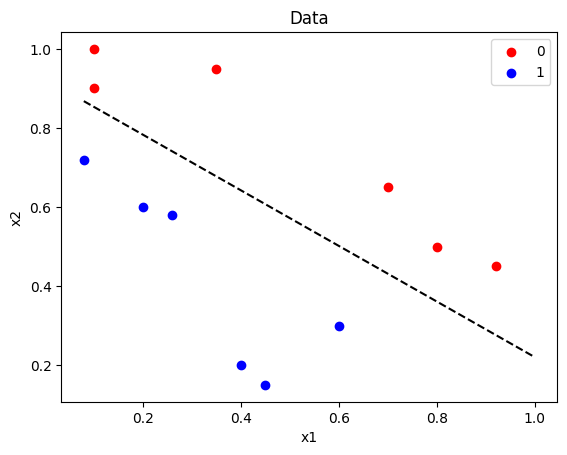

In [37]:
visualize_final(data, 'Data', 'y', 'x1', 'x2')